## Инициализация

In [2]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import meep.adjoint as mpa
import autograd.numpy as npa
from autograd import tensor_jacobian_product, grad
mp.verbosity(0)

'''Физические параметры'''
Si = 3.4
air = 1
wl = 1.1 # central wavelength (micron)
fcen = 1/wl #central frequency
df = 0.1 # pulse width (in frequency)
r = wl/(Si*2*np.pi)*16 # disk radius

wg_width = 0.5 # waveguide width (micron)
distance = 0.1 # расстояние между краями диска и волновода (микроны)
angle = np.radians(45) # угол между краями углубления и центром диска (градусы)
wg_center_y = (r+distance)*np.sqrt(np.cos(angle)) + wg_width/2
wg_center = mp.Vector3(0, wg_center_y , 0)


'''Параметры симуляции'''
time = 300 # время симуляции после затухания источника
resolution = 50 # количество пикселей на один микрон
pad = 1 # padding between waveguide and edge of PML
pml_thickness = 0.5  # thickness of PML
sxy = int(2*(r + pad + pml_thickness))  # cell size
wg_size = mp.Vector3(sxy, wg_width, 0)
src_center = mp.Vector3(-0.9*r) # Координата источника

flux_coord = sxy/2 - pml_thickness - 0.1 #удаленность flux от центра (0.1 это расстояние между flux мониторами и pml)

geometry_wg = [
    mp.Block(size=wg_size, center=wg_center, material=mp.Medium(index=Si)), # волновод
    mp.Cylinder(radius=r, center=(0, distance, 0), material=mp.Medium(index=air)), # вырез в волноводе
    mp.Cylinder(radius=r, center=(0, 0, 0), material=mp.Medium(index=Si)), # диск  
] 

geometry_simple = [
    mp.Cylinder(radius=r, center=(0, 0, 0), material=mp.Medium(index=Si)), # диск  
] 

src = [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df), 
                 mp.Ez, 
                 center = src_center,
                 size = mp.Vector3(0))
]
sim = mp.Simulation(
    cell_size=mp.Vector3(sxy, sxy),
    geometry=geometry_simple,
    sources=src,
    resolution=resolution,
    boundary_layers=[mp.PML(pml_thickness)],
    default_material=mp.Medium(index=air)
)


## Flux

### Без волновода

FloatProgress(value=0.0, description='0% done ', max=400.0)

<Axes: xlabel='X', ylabel='Y'>

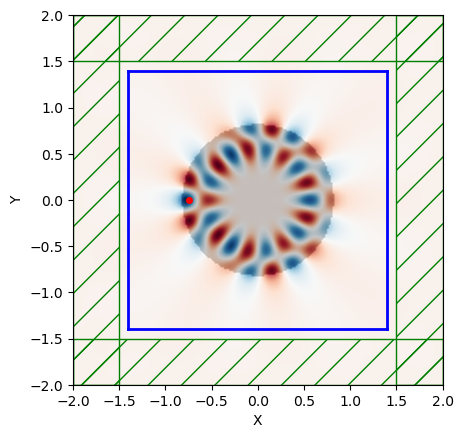

In [96]:
nfreq = 100 # количество частот для подсчета
fluxes = [mp.FluxRegion(center=mp.Vector3(0, -flux_coord), size=mp.Vector3(2*flux_coord, 0)),
         mp.FluxRegion(center=mp.Vector3(flux_coord, 0), size=mp.Vector3(0, 2*flux_coord)),
         mp.FluxRegion(center=mp.Vector3(0, flux_coord), size=mp.Vector3(2*flux_coord, 0)),
         mp.FluxRegion(center=mp.Vector3(-flux_coord, 0), size=mp.Vector3(0, 2*flux_coord))]

sim.geometry = geometry_simple
sim.reset_meep()
borders_flux = sim.add_flux(fcen, df, nfreq, *fluxes)

sim.run(until_after_sources=time)
sim.plot2D(fields=mp.Ez)

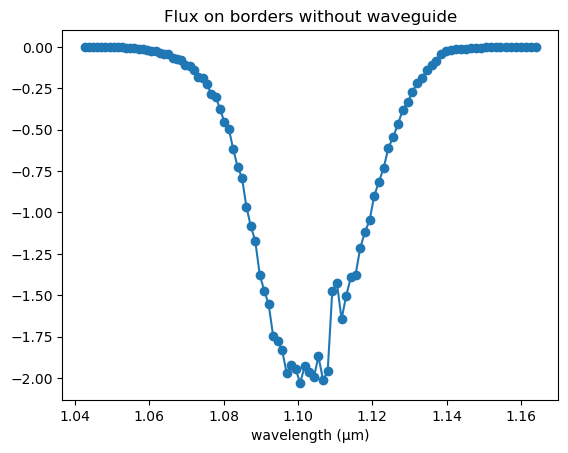

In [93]:
flux_freqs = np.array(mp.get_flux_freqs(borders_flux))
flux_on_borders = np.array(mp.get_fluxes(borders_flux))
plt.figure()
plt.title("Flux on borders without waveguide")
plt.plot(1/flux_freqs, flux_on_borders, 'o-')
plt.xlabel("wavelength (μm)")
plt.show()


### С волноводом

FloatProgress(value=0.0, description='0% done ', max=400.0)

<Axes: xlabel='X', ylabel='Y'>

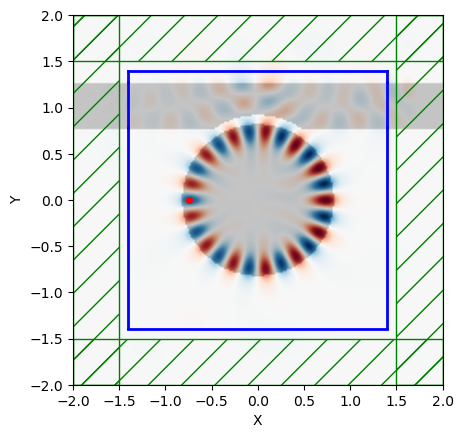

In [97]:

wg_fluxes_reg = [mp.FluxRegion(center=mp.Vector3(flux_coord, wg_center_y), size=mp.Vector3(0,wg_width)),
            mp.FluxRegion(center=mp.Vector3(-flux_coord, wg_center_y), size=mp.Vector3(0,wg_width)),]

size_bottom = flux_coord + wg_center_y - wg_width/2
coord_bottom = -flux_coord/2 + wg_width-distance
size_top = flux_coord  - wg_center_y - wg_width/2
coord_top = (flux_coord + wg_center_y + wg_width/2)/2

not_wg_fluxes_reg = [mp.FluxRegion(center=mp.Vector3(flux_coord, coord_bottom), size=mp.Vector3(0, size_bottom)), #right down
          mp.FluxRegion(center=mp.Vector3(flux_coord, coord_top), size=mp.Vector3(0, size_top)), #right up
         mp.FluxRegion(center=mp.Vector3(-flux_coord, coord_bottom), size=mp.Vector3(0, size_bottom)), #left down
          mp.FluxRegion(center=mp.Vector3(-flux_coord, coord_top), size=mp.Vector3(0, size_top)), #left up
         mp.FluxRegion(center=mp.Vector3(0, -flux_coord), size=mp.Vector3(2*flux_coord, 0)), #bottom
         mp.FluxRegion(center=mp.Vector3(0, flux_coord), size=mp.Vector3(2*flux_coord, 0)), #top
         ]
sim.geometry = geometry_wg
sim.reset_meep()

wg_fluxes = sim.add_flux(fcen, df, nfreq, *wg_fluxes_reg)
not_wg_fluxes = sim.add_flux(fcen, df, nfreq, *not_wg_fluxes_reg)

sim.run(until_after_sources=time)
sim.plot2D(fields=mp.Ez)

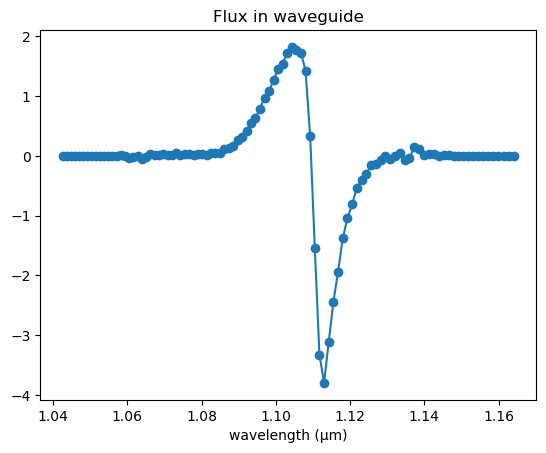

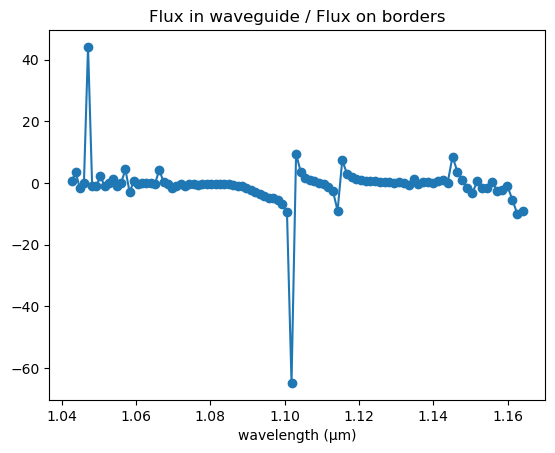

In [95]:
flux_freqs = np.array(mp.get_flux_freqs(not_wg_fluxes)) # частоты 
flux_in_wg = np.array(mp.get_fluxes(wg_fluxes)) # внутри волновода 
flux_out_wg = np.array(mp.get_fluxes(not_wg_fluxes)) # вне волновода

plt.figure()
plt.title("Flux in waveguide")
plt.plot(1/flux_freqs, flux_in_wg, 'o-')
plt.xlabel("wavelength (μm)")
plt.show()

plt.figure()
plt.title("Flux in waveguide / Flux on borders")
plt.plot(1/flux_freqs, flux_in_wg/flux_out_wg, 'o-')
plt.xlabel("wavelength (μm)")
plt.show()


## Добротность

In [ ]:
'''Harminv'''
monitors = [mp.Vector3(0), 
            mp.Vector3(0.25*r), 
            mp.Vector3(0.5*r), 
            mp.Vector3(0.75*r),
            mp.Vector3(1*r),
            mp.Vector3(1.25*r), 
            wg_center]

monitors_names = ['Центр диска', 
                  '0.25r', 
                  '0.5r', 
                  '0.75r', 
                  'r',
                  '1.25r',
                  'Волновод']

harminv_monitors = [mp.Harminv(mp.Ez, mon, fcen, df) for mon in monitors]
sim.reset_meep()
sim.run(mp.after_sources(*harminv_monitors),
        until_after_sources=time)


In [110]:
# Резонансные частоты и добротности для каждой моды каждой точки
res_freqs = []
Qs = []
for h in harminv_monitors:
    res_freqs.append([m.freq for m in h.modes])
    Qs.append([m.Q for m in h.modes])

print("Резонансная частота")
for name, h in zip(monitors_names, res_freqs):
    print(name, np.round(h,3))

print()
print("Добротность")
for name, h in zip(monitors_names, Qs):
    print(name, np.round(h,1))
    

Резонансная частота
Центр диска [0.879 0.879 0.901 0.911 0.941 0.958]
0.25r [0.879 0.881 0.901 0.911 0.941 0.956]
0.5r [0.879 0.88  0.9   0.941 0.957]
0.75r [0.877 0.879 0.887 0.9   0.941 0.956]
r [0.879 0.9   0.941 0.953]
1.25r [0.879 0.88  0.9   0.921 0.941 0.957]
Волновод [0.879 0.879 0.901 0.941 0.955]

Добротность
Центр диска [  65.9  525.9  248.    50.4 1229.   161.7]
0.25r [ 538.2   78.7  121.1   54.  1292.8  122.4]
0.5r [ 536.4   58.1  154.5 1222.7  174. ]
0.75r [  59.9  527.7 1120.2  153.7 1306.2  187.6]
r [ 523.7  153.3 1305.5   53.2]
1.25r [ 529.9   62.1  158.7  181.  1302.9  177.8]
Волновод [ 526.9   98.4  267.1 1484.1  521. ]


## Визуализация

In [ ]:

sim.plot2D(fields=mp.Ez, field_parameters={'alpha':0.9, 'cmap':'RdBu'})
plt.savefig("microdisk.png")
plt.show()


In [ ]:
def animation(from_start, anim_time, filename):
    if from_start:
        sim.reset_meep()
    animate_sim = mp.Animate2D(fields=mp.Ez,
                           normalize = True,
                           field_parameters={'alpha':0.9, 'cmap':'RdBu'})
    
    sim.run(mp.at_every(1,animate_sim), until=anim_time)
    plt.close()
    animate_sim.to_gif(10, f"{filename}.gif")
    animate_sim.to_jshtml(10)


In [8]:
def plot_field_module(sim, size, center, show_material, filename):
    dielectric = sim.get_array(
        component=mp.Dielectric,
        size=size, center=center)
    dielectric = np.transpose(dielectric)
    
    Ex = sim.get_array(
        component=mp.Ex,
        size=size, center=center)
    Ey = sim.get_array(
        component=mp.Ey,
        size=size, center=center)
    Ez = sim.get_array(
        component=mp.Ez,
        size=size, center=center)
    
    # plotting
    fig, ax = plt.subplots()
    if show_material:
        ax.imshow(
            dielectric,
            cmap='binary',
            origin='lower'
            )
        
    im = ax.imshow(
        np.sqrt(np.abs(Ex)**2+np.abs(Ey)**2+np.abs(Ez)**2).T,
        origin='lower',
        alpha=1,
        cmap='RdBu'
        )
    
    plt.colorbar(im,label=r'$|E|$')
    ax.set_axis_off()
    plt.savefig(f"{filename}.png")

## Оптимизация

In [64]:
'''Optimization'''
minimum_length = 0.09
eta_e = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e
design_region_resolution = int(resolution)
design_region_width = 2*r
design_region_height = wg_width + 2*distance
design_region_center = wg_center

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), mp.Medium(index=air), mp.Medium(index=Si), grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=design_region_center,
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

sim.geometry.append(mp.Block(center=design_region.center, size=design_region.size, material=design_variables)) # оптимизируемая зона

In [4]:
def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    
    # interpolate to actual materials
    return projected_field.flatten()


# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

circle_mask = (X_g**2 + Y_g**2 <= r)
wg_mask = (X_g == -design_region_width / 2) & (Y_g <= wg_width / 2)

# Define the core mask
'''left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
top_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g + arm_separation / 2) <= waveguide_width / 2
)
bottom_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g - arm_separation / 2) <= waveguide_width / 2
)'''
Si_mask = circle_mask

# Define the cladding mask
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
air_mask = border_mask.copy()
air_mask[Si_mask] = False




In [5]:


field = mpa.FourierFields(
    sim,
    mp.Volume(
        center=src_center,
        size=mp.Vector3(0),
    ),
    component=mp.Ez
)

def J(field):
    return npa.mean(field)

ob_list = [field]
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=df,
    nf=10,
    decay_by=1e-5,
)


Starting forward run...
[-0.34529019 -0.19075447j  0.41469552 +0.47032091j
 -0.44882027 -0.82796323j 30.81459987+18.85444082j
  0.38416196 +0.06266613j  0.37477586 +0.05080985j
 -0.59771874 -0.23603476j  0.45773817 +0.3572174j
 -0.23333752 -0.39323268j  0.03802967 +0.38650896j]
(3.085883432917698+1.8533978926739458j)


/home/masha/conda/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/masha/conda/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


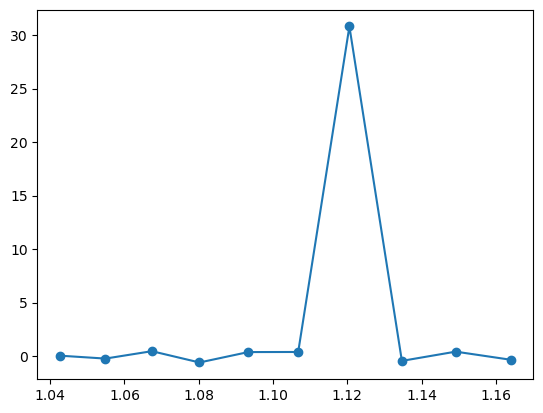

In [7]:
x = np.ones((Nx*Ny,)) * 0
f0, _ = opt([mapping(x, eta_i, 128)], need_gradient=False)
frequencies = opt.frequencies
[dftfld] = opt.get_objective_arguments()
plt.figure()
plt.plot(1 / frequencies, dftfld, "-o")
print(dftfld)
print(f0)


In [9]:

evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )

    evaluation_history.append(np.max(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)